### Stock prediction model

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

Extract data from yahoo Finance

In [2]:
start = datetime.datetime(2009, 9, 3)
end = datetime.datetime(2019, 9, 3)

df = web.DataReader("GOOG", 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-09-03,228.269394,226.650452,227.058929,227.905746,3304600.0,227.905746
2009-09-04,230.436264,227.039001,227.930664,229.788696,3009500.0,229.788696
2009-09-08,232.623077,227.068893,231.278107,228.453705,5333300.0,228.453705
2009-09-09,232.264420,228.543365,228.672882,231.118713,4407100.0,231.118713
2009-09-10,234.590698,230.137390,232.453705,234.590698,5088100.0,234.590698


Calculate rolling average for the last 100 days

In [3]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail()

Date
2019-08-28    1156.068495
2019-08-29    1155.958595
2019-08-30    1155.867095
2019-09-03    1155.529395
2019-09-04    1155.297295
Name: Adj Close, dtype: float64

Visualize Moving Averages with matplot

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

Adjusting the size of matplotlib

In [5]:
import matplotlib as mpl
mpl.rc('figure', figsize=(10, 7))
mpl.__version__

'3.1.0'

Adjusting the style of matplotlib

In [6]:
style.use('ggplot')

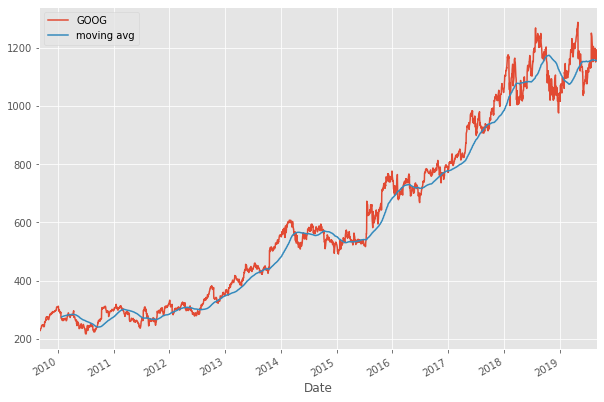

In [7]:
close_px.plot(label='GOOG')
mavg.plot(label='moving avg')
plt.legend()

GOOG stock showcases strong increating trend from 2015-2018.

Calculate Return Deviation to determine risk and return
#returns = (close price t) / (close price t-1) - 1


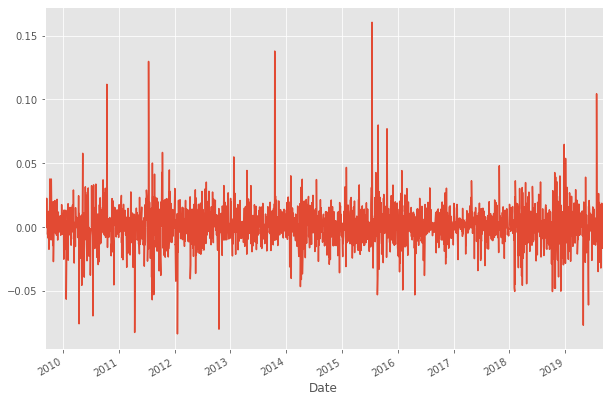

In [8]:
returns = close_px/ close_px.shift(1) -1
returns.plot(label='return')

Based on GOOG returns, this may not be a good stock to invest if you are risk averse with over 5% drop in year 2010, 2011, 2012, 2013, and 2019.

Now let's analyze competitor stocks compare to GOOG.

In [9]:
dfcomp = web.DataReader(['GOOG', 'AABA', 'EXPE'],'yahoo',start=start,end=end)['Adj Close']

dfcomp.head()

Calculate stocks percentage change and correction

In [10]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

In [11]:
print(corr)

Symbols      AABA      EXPE     GOOG
Symbols                             
AABA     1.000000  0.302431  0.45210
EXPE     0.302431  1.000000  0.32605
GOOG     0.452100  0.326050  1.00000


Positive, but not strong correlation among the three stocks. AABA and GOOG have the highest correlation of 45%.

Visualize return distribution of AABA and GOOG

Text(0, 0.5, 'GOOG returns')

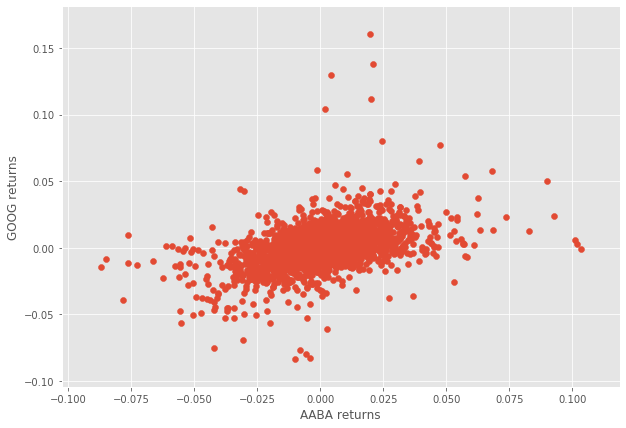

In [12]:
plt.scatter(retscomp.AABA, retscomp.GOOG)
plt.xlabel('AABA returns')
plt.ylabel('GOOG returns')

 Plotting the scatter_matrix to visualize possible correlations among the 3 stocks. We will run Kernel Density Estimate (KDE) for data smoothing to estimate the overall distribution.

In [13]:
import pandas.plotting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000212EBFDFA58>,
      dtype=object)

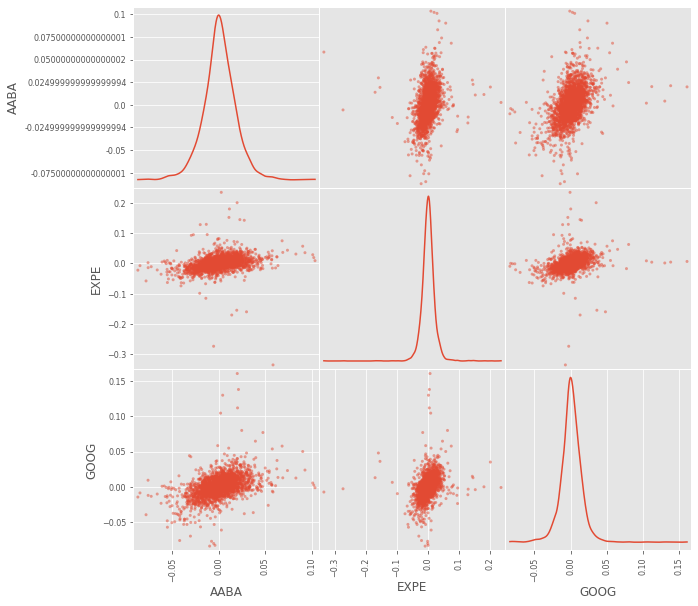

In [14]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10))

The distributions among the 3 stocks are approximately positive correlated.

Using heatmap below to prove the positive correlations among stock.

([<matplotlib.axis.YTick at 0x212ecb2e668>,
 <a list of 3 Text yticklabel objects>)

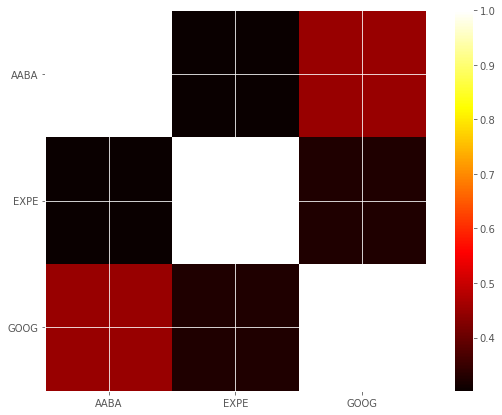

In [15]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

Analyze stocks returns rate (average returns) and risk (standard deviation of returns)

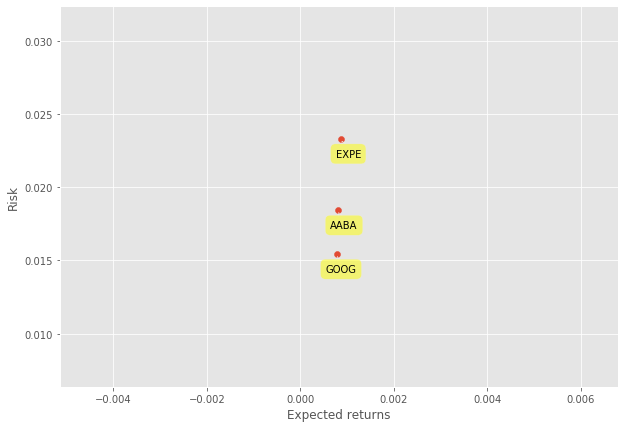

In [16]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

As expected, stocks with higher risk provide higher returns. EXPE > AABA > GOOG

### Stocks Price Prediction

Create Stock Price Prediction machine learning models:
1- Simple Linear Analysis
2- Quadratic Discriminant Analysis (QDA)
3- K-Nearest Neighbor (KNN)

### 1- Linear Regression

In [17]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-09-03,228.269394,226.650452,227.058929,227.905746,3304600.0,227.905746
2009-09-04,230.436264,227.039001,227.930664,229.788696,3009500.0,229.788696
2009-09-08,232.623077,227.068893,231.278107,228.453705,5333300.0,228.453705
2009-09-09,232.264420,228.543365,228.672882,231.118713,4407100.0,231.118713
2009-09-10,234.590698,230.137390,232.453705,234.590698,5088100.0,234.590698


Create test and train dataset

Calculate High-Low percentage and Percentage change

In [18]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

Pre-processing & Cross Validation

Drop missing value

In [19]:
dfreg.fillna(value=-99999, inplace=True)

In [20]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-09-03,227.905746,3304600.0,0.710356,0.372950
2009-09-04,229.788696,3009500.0,1.478429,0.815174
2009-09-08,228.453705,5333300.0,2.431208,-1.221215
2009-09-09,231.118713,4407100.0,1.610019,1.069576
2009-09-10,234.590698,5088100.0,1.898331,0.919320


In [21]:
dfreg.shape

(2517, 4)

Create test and train dataset

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dfreg.drop("Adj Close", axis=1), dfreg['Adj Close'], test_size = 0.2,\
                                                    random_state=112)

### 1-Linear Regression

import Linear Regression class



In [23]:
from sklearn.linear_model import LinearRegression

create an object of LinearRegression class


In [24]:
clfreg = LinearRegression(normalize=True)

Fit the linear regression model to our training set

In [25]:
clfreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

Make predictions on the test set

In [26]:
predictions = clfreg.predict(X_test)

Compare a sample of 5 actual Y values from test set and corresponding predicted values

In [45]:
pd.DataFrame({'actual value': Y_test, 'predictions':predictions}).sample(5)

,actual value,predictions
Date,,
2018-10-02,1200.109985,774.593429
2016-05-06,711.119995,764.610360
2015-08-17,660.869995,791.187503
2016-07-06,697.770020,785.902049
2014-12-15,512.393250,675.865813


Check the  R2  value

In [28]:
clfreg.score(X_test, Y_test)

0.3669795089775141

Linear regression is not a good prediction model for the stock dataset.

 import list of sklearn packages below

In [29]:
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### 2- Quadratic Regression

In [30]:
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, Y_train)

C:\Users\Yan family\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21077e-31): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [31]:
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, Y_train)

C:\Users\Yan family\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.05215e-46): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

### 3- KNN (K Nearest Neighbor)

In [32]:
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

Evaluation of models

In [46]:
confidencereg = clfreg.score(X_test, Y_test)
confidencepoly2 = clfpoly2.score(X_test,Y_test)
confidencepoly3 = clfpoly3.score(X_test,Y_test)
confidenceknn = clfknn.score(X_test, Y_test)

In [47]:
print(confidencereg)
print(confidencepoly2)
print(confidencepoly3)
print(confidenceknn)

0.3669795089775141
0.4878898080579989
0.5422456530058111
0.3312209514768436


Quadratic models performs well, but Linear Regression and KNN model perform poorly.

### Visualize results w matplotlib

Create prediction

In [76]:
predictionsreg = clfreg.predict(X_test)
predictionspoly2 = clfpoly2.predict(X_test)
predictionspoly3 = clfpoly3.predict(X_test)
predictionsknn = clfknn.predict(X_test)

In [77]:
dfv= pd.DataFrame({'actual value': Y_test, 'predictionsreg':predictionsreg
                  , 'predictionspoly2':predictionspoly2, 'predictionspoly3':predictionspoly3
                  , 'predictionsknn':predictionsknn}).sample(10)

In [95]:
dfv=dfv.sort_index()

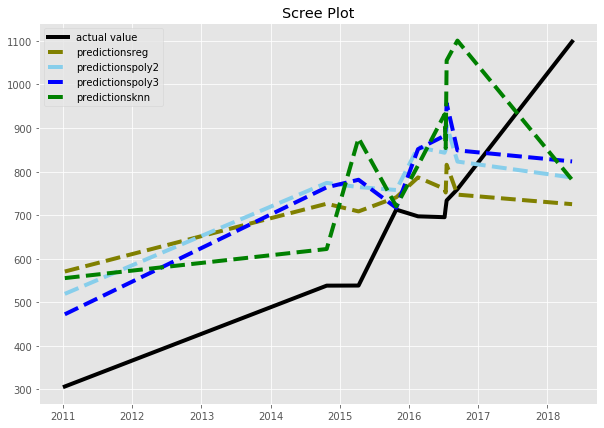

In [106]:
plt.plot( dfv['actual value'], data=df, color='black', linewidth=4)
plt.plot( dfv['predictionsreg'], data=df, color='olive', linewidth=4, linestyle='dashed')
plt.plot( dfv['predictionspoly2'], data=df, color='skyblue', linewidth=4, linestyle='dashed')
plt.plot( dfv['predictionspoly3'], data=df, color='blue', linewidth=4, linestyle='dashed')
plt.plot( dfv['predictionsknn'], data=df, color='green', linewidth=4, linestyle='dashed')
plt.title('Stock prediction')
plt.legend(loc='best')
plt.show()